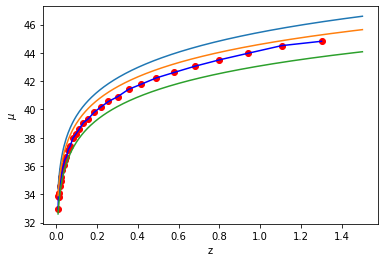

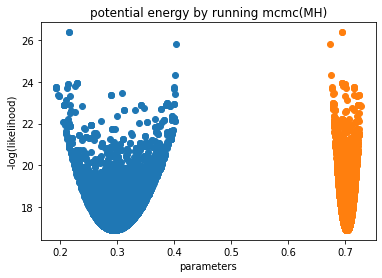

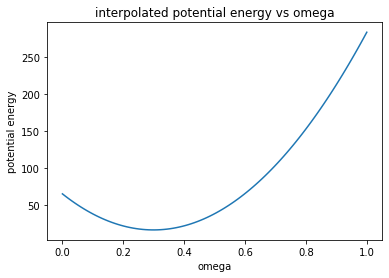

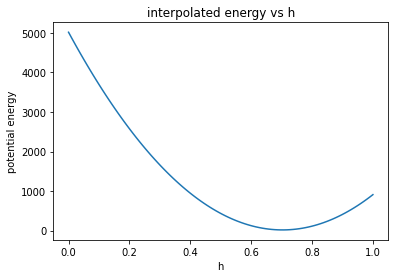

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math as math
from autograd import elementwise_grad
from scipy import random
from random import gauss
from autograd import grad
from operator import sub
import numpy.polynomial.polynomial as poly
%matplotlib inline
# Reading the covariance matrix and reshaping it into 31x31 matrix.
 
cov = np.loadtxt(r"/content/jla_mub_covmatrix.txt",unpack=True).reshape(31,31)
#cov=cov.reshape(31,31)
InvC = np.linalg.inv(cov)
 
# Read in the Supernova data file:
z,mu=np.loadtxt(r"/content/jla_mub.txt",delimiter=" ",unpack=True)
 
# Number of MCMC samples and number of parameters:
nsamples = 10000
npars    = 2
 
# Sigma for each parameters:
sigomega=0.01
sigmu=0.01
 
# number of data points:
n = 31
 
# Functions to approximate the luminosity distance and distance modulus:
def mu_model(z,omega,h):
    # Distance modulus at redshift z, for flat Universe with parameters Omegam, h
    mu_model=25.0 - 5.0*math.log10(h) + 5.0*math.log10(DLstar(z,omega))
    return mu_model
 
def DLstar(z,omega):
    # Luminosity Distance at redshift z, in Mpc/h, for flat Universe with parameters Omegam, h
    DLval=3000.0*(1.0+z)*(eta(1.0,omega)-eta(1.0/(1.0+z), omega))
    return DLval
 
def eta( a, omega ):
    s=np.power(1.0/omega-1.0,1.0/3.0)
    etaval=2.0 * np.power(np.power(s,3)+1.0,0.5) * np.power(np.power(a,-4)-0.1540*s*np.power(a,-3)+
                                                           0.4304*np.power(s,2)*np.power(a,-2)+
                                                            0.19097*np.power(s,3)/a+
                                                        0.066941*np.power(s,4),-0.125)   
    return etaval
 
 
 
 
# Declare an empty array of the parameter values of each point. 
# Parameter 0 = Omega_m
# Parameter 1 = h
# Parameter npars will be used to store the ln(likelihood)
Theta   = np.empty([nsamples,5])
 
# list to store mu(data)-mu(theory), temporarily:
diff = np.empty(n)
 
# Random starting point in parameter space; each parameter in range (0,1).
# Set initial likelihood to low value so next point is accepted :
Theta[0,:] = [np.random.uniform(), np.random.uniform(),-1.e100,np.random.uniform(),np.random.uniform()]
 
 
 
    
# Plot the data:
fig = plt.figure()
plt.plot(z,mu,'ro',z,mu,'b')
npts    = 300
z_plot  = np.linspace(0.01, 1.5, npts)
mu_plot = np.empty(npts)
 
# Plot a few theoretical curves on top of the data:
for i in range (npts):
    mu_plot[i]=mu_model(z_plot[i], 0.2, 0.4) #PLOTTING MU(Y) PLOT AS A FUNCTION OF VARIABLE Z(x)(CREATED USING LINSPACE)with PARAMETER 0.2,0.4
plt.plot(z_plot,mu_plot)
plt.xlabel('z')
plt.ylabel(r'$\mu$')
for i in range (npts):
    mu_plot[i] = mu_model(z_plot[i], 0.5, 0.5)
plt.plot(z_plot,mu_plot)
for i in range (npts):
    mu_plot[i] = mu_model(z_plot[i], 0.8, 0.9)
plt.plot(z_plot,mu_plot)
plt.show()
fig.savefig('graph1.jpg')
 
 
 
# Defining likelihood function for parameters omega and h:
 
def lnL(omega, h):
    "Ln of likelihood for flat Universe and SN distance modulus data"
 
# Treat unphysical regions by setting likelihood to (almost) zero:    
    if(omega<=0 or h<=0):
        lnL = -1.e100
    else:
            
# Compute difference with theory mu at redshifts of the SN, for trial Omegam, h:
        for j in range (n):
            diff[j] = mu[j]-mu_model(z[j],omega,h)
 
# Compute ln(likelihood) assuming gaussian errors (double sum done using vector/matrix ops):
        lnL = -0.5*np.dot(diff,np.dot(InvC,diff))
        
    return lnL
 
Theta[0,npars] = lnL(Theta[0,0], Theta[0,1]) #PASSING PARAMETER TO LIKELIHOOD FUNCTION I.E omega and h to calculate likehood which will be randomize later
 
for i in range(1,nsamples):    
    lnLPrevious = Theta[i-1,npars]  #random likehood funtion (mu as a function of omega and h which can be randomised assuming there gaussian distribution)
    OmegamProp = np.random.normal(Theta[i-1,0],sigomega)
    hProp      = np.random.normal(Theta[i-1,1],sigmu)
    
    lnLProp    = lnL(OmegamProp,hProp)
 
 
# Metroplis-Hastings algorithm:
 
    if(lnLProp > lnLPrevious):
# Accept point if likelihood has gone up:
        Theta[i,0]     = OmegamProp
        Theta[i,1]     = hProp
        Theta[i,npars] = lnLProp
    else:
# Otherwise accept it with probability given by ratio of likelihoods:
        alpha = np.random.uniform()   #default values btw 0-1
    
#        print(lnLProp,lnLPrevious,alpha)
        if(lnLProp - lnLPrevious > np.log(alpha)):
            Theta[i,0]     = OmegamProp
            Theta[i,1]     = hProp
            Theta[i,npars] = lnLProp
#            print('Accepted')
        else:
# Repeat the previous point in the chain:
            Theta[i,0]     = Theta[i-1,0]
            Theta[i,1]     = Theta[i-1,1]
            Theta[i,npars] = lnLPrevious
#            print('Rejected')
 
zz=[]
for i in range(len(Theta[:,0])):
    zz.append(-lnL(Theta[i,0],Theta[i,1]))
 
xo=np.mean(Theta[:,0])
yo=np.mean(Theta[:,1])
xos=np.std(Theta[:,0])
yos=np.std(Theta[:,1])
 
#plt.plot(Theta[:,0],zz,Theta[:,1],zz)
nburn = math.floor(nsamples/10)
fig=plt.figure()
plt.title('potential energy by running mcmc(MH)')
plt.xlabel('parameters')
plt.ylabel('-log(likelihood)')
plt.plot(Theta[nburn:,0],zz[nburn:],'o',Theta[nburn:,1],zz[nburn:],'o')
fig.savefig('graph2.jpg')
plt.show()
data=zz[nburn:]
x=Theta[nburn:,0]
y=Theta[nburn:,1]
data3=data
 
u=np.argwhere(x==np.min(x))
 
#plt.plot(x[u[0][0]],data[u[0][0]],'o',color='black')
v=np.argwhere(data<data[u[0][0]])
olddata=[]
xold=[]
for i in range(len(v)):
    olddata.append(data[v[i][0]])
    xold.append(x[v[i][0]])
olddata=np.array(olddata)
xold=np.array(xold)
 
#plt.plot(xold,olddata,'o')
u=np.argwhere(xold==np.min(xold))
#plt.plot(xold[u[0][0]],olddata[u[0][0]],'o',color='black')
u=u[0][0]
v=np.argwhere(olddata==np.min(olddata))
#plt.plot(xold[v[0][0]],olddata[v[0][0]],'o',color='black')
v=v[0][0]
mindata=olddata[v]
w=np.argwhere(xold==np.max(xold))
#plt.plot(xold[w[0][0]],olddata[w[0][0]],'o',color='black')
w=w[0][0]
maxdata=olddata[w]
#data sorting 
xnew=[]
newdata=[]
xnew.append(xold[u])
newdata.append(olddata[u])
data=olddata
x=xold
x2=xold
data2=olddata
 
c=0
e=0
while 1:
    c=c+1
    xold=[]
    olddata=[]
    vv=np.argwhere(data<data[u])
    
    for i in range(len(vv)):
        olddata.append(data[vv[i][0]])
        xold.append(x[vv[i][0]])
    olddata=np.array(olddata)
    xold=np.array(xold)
    uu=np.argwhere(xold==np.min(xold))
    xnew.append(xold[uu[0][0]])
    newdata.append(olddata[uu[0][0]])
    x=xold
    data=olddata
    u=uu[0][0]
    if newdata[c]==mindata:
        break
 
xnew2=[]
newdata2=[]
while 1:
    xold=[]
    olddata=[]
    vv=np.argwhere(data2<data2[w])
    for i in range(len(vv)):
        olddata.append(data2[vv[i][0]])
        xold.append(x2[vv[i][0]])
    olddata=np.array(olddata)
    xold=np.array(xold)
    ww=np.argwhere(xold==np.max(xold))
    xnew2.append(xold[ww[0][0]])
    newdata2.append(olddata[ww[0][0]])
    x2=xold
    data2=olddata
    w=ww[0][0]
    if newdata2[e]==mindata:
        newdata2.remove(newdata2[e])
        xnew2.remove(xnew2[e])
        break
    else:e=e+1
xnew2=xnew2[::-1]
newdata2=newdata2[::-1]
xnew.extend(xnew2)
newdata.extend(newdata2)
 
#plt.plot(xnew,newdata,color='black')   #   comment this 
#plt.show()
Ux=newdata   
xs=np.linspace(0,1,100)
a = poly.polyfit(xnew,Ux,2)
ux = poly.polyval(xs,a)
 
#to create the polynomial function:
ux = poly.Polynomial(a)   
fig=plt.figure()
plt.title('interpolated potential energy vs omega') 
plt.xlabel('omega')
plt.ylabel('potential energy')
plt.plot(xs,ux(xs))
 
plt.show()
fig.savefig('graph3.jpg')
 
 
#extract y data
u=np.argwhere(y==np.min(y))
 
#plt.plot(Theta[nburn:,0],zz[nburn:],'o',Theta[nburn:,1],zz[nburn:],'o')
#plt.plot(y[u[0][0]],data3[u[0][0]],'o',color='black')
v=np.argwhere(data3<data3[u[0][0]])
olddata=[]
yold=[]
for i in range(len(v)):
    olddata.append(data3[v[i][0]])
    yold.append(y[v[i][0]])
olddata=np.array(olddata)
yold=np.array(yold)
 
#plt.plot(yold,olddata,'o')
u=np.argwhere(yold==np.min(yold))
#plt.plot(yold[u[0][0]],olddata[u[0][0]],'o',color='black')
u=u[0][0]
v=np.argwhere(olddata==np.min(olddata))
#plt.plot(yold[v[0][0]],olddata[v[0][0]],'o',color='black')
v=v[0][0]
mindata=olddata[v]
w=np.argwhere(yold==np.max(yold))
#plt.plot(yold[w[0][0]],olddata[w[0][0]],'o',color='black')
w=w[0][0]
maxdata=olddata[w]
#data sorting 
ynew=[]
newdata=[]
ynew.append(yold[u])
newdata.append(olddata[u])
data=olddata
y=yold
y2=yold
data2=olddata
c=0
e=0
while 1:
    c=c+1
    yold=[]
    olddata=[]
    vv=np.argwhere(data<data[u])
    
    for i in range(len(vv)):
        olddata.append(data[vv[i][0]])
        yold.append(y[vv[i][0]])
    olddata=np.array(olddata)
    yold=np.array(yold)
    uu=np.argwhere(yold==np.min(yold))
    ynew.append(yold[uu[0][0]])
    newdata.append(olddata[uu[0][0]])
    y=yold
    data=olddata
    u=uu[0][0]
    if newdata[c]==mindata:
        break
 
ynew2=[]
newdata2=[]
while 1:
    yold=[]
    olddata=[]
    vv=np.argwhere(data2<data2[w])
    for i in range(len(vv)):
        olddata.append(data2[vv[i][0]])
        yold.append(y2[vv[i][0]])
    olddata=np.array(olddata)
    yold=np.array(yold)
    ww=np.argwhere(yold==np.max(yold))
    ynew2.append(yold[ww[0][0]])
    newdata2.append(olddata[ww[0][0]])
    y2=yold
    data2=olddata
    w=ww[0][0]
    if newdata2[e]==mindata:
        newdata2.remove(newdata2[e])
        ynew2.remove(ynew2[e])
        break
    else:e=e+1
ynew2=ynew2[::-1]
newdata2=newdata2[::-1]
ynew.extend(ynew2)
newdata.extend(newdata2)
#plt.plot(ynew,newdata,color='black')    #comment this
#plt.show()
 
Uy=newdata
ys=np.linspace(0,1,100)
b = poly.polyfit(ynew,Uy, 2)
uy = poly.polyval(ys,b)
#to create the polynomial function:
fig=plt.figure()
plt.title('interpolated energy vs h')
plt.xlabel('h')
plt.ylabel('potential energy')
uy = poly.Polynomial(b)    
plt.plot(ys,uy(ys))
plt.show()
fig.savefig('graph4.jpg')

#HMC START HERE---------------------------------------

In [ ]:
#HMC start
nsamples=1000

def U(omega,h):
    jjj=-1*lnL(omega,h)
    return jjj
 
def U2(omega,h):
    #f=-1*lnL(0.3,h)+-1*lnL(omega,0.7)                                        #interpolated energy for calculation of gradient 
    f=(b[2]*h**2+b[1]*h+b[0])/2 + (a[2]*omega**2+a[1]*omega+a[0])/2
    return f
 
def gradU(omega,h):
    omega_= elementwise_grad(U2,0)
    h_=elementwise_grad(U2, 1)
    do=omega_(omega,h)
    dh=h_(omega,h)
    gg=np.empty([1,2])
    gg[0,0]=do
    gg[0,1]=dh
    return gg
 

Theta   = np.empty([nsamples,5])
 
# Random starting point in parameter space; each parameter in range (0,1).
# Set initial likelihood to low value so next point is accepted :
Theta[0,:] = [np.random.normal(xo,xos), np.random.normal(yo,yos),-1.e100,np.random.uniform(),np.random.uniform()]
#Theta[0,:] = [np.random.uniform(), np.random.uniform(),-1.e100,np.random.uniform(),np.random.uniform()]
 
Theta[0,npars] = lnL(Theta[0,0], Theta[0,1]) 
accep=0
omegap=[]
hp=[]
energyc=[]
energyc.append(0)
x_current=Theta[0,0:2]   
print(x_current[0],x_current[1])
omegap.append(0)
hp.append(0)
 
for i in range(1,nsamples):
    u=np.empty([1,2])
    u[0,0]=gauss(0,1)
    u[0,1]=gauss(0,1)                                              #intial momentum corresponding to each paramter or position
    x_current=np.empty([1,2])
    x_current[0,0]=Theta[i-1,0]                                    #initial position for both omega and h 
    x_current[0,1]=Theta[i-1,1]
    x=x_current
    u_current=u
    Theta[i-1,3:5]=u_current
    sigmai=random.choice(np.sqrt(np.diagonal(cov)))
    epsilon=0.01*sigmai
    NN=int(np.random.randint(0,3)*sigmai/epsilon)
 
 
    u=u-epsilon*gradU(x[0,0],x[0,1])/2
    for j in range(1,NN):                                           #leap frog move
        x=x+epsilon*u
        if j!=NN:
            u=u-epsilon*gradU(x[0,0],x[0,1])
    u=u-epsilon*gradU(x[0,0],x[0,1])/2
    u=-1*u
 
    current_U=U(x_current[0,0],x_current[0,1])
    current_K=u_current[0,0]*u_current[0,0]+u_current[0,1]*u_current[0,1]
    current_K=current_K/2
    proposed_U=U(x[0,0],x[0,1])
    proposed_K=u[0,0]*u[0,0]+u[0,1]*u[0,1]
    proposed_K=proposed_K/2
    dH=-current_U+proposed_U-current_K+proposed_K
    if np.exp(-dH)>1:
        Theta[i,0:2]=x
        accep=accep+1
        omegap.append(u[0,0])
        hp.append(u[0,1])
        energyc.append(proposed_U+proposed_K)
    else:
        jp=np.random.uniform()
        if np.exp(-dH)>jp:
            Theta[i,0:2]=x
            accep=accep+1
            omegap.append(u[0,0])
            hp.append(u[0,1])
            energyc.append(proposed_U+proposed_K)
        else:
            Theta[i,0:2]=x_current                                        
            omegap.append(u_current[0,0])
            hp.append(u_current[0,1])
            energyc.append(current_U+current_K)
 
#HMC end ----------------------------------------------------------------------------------------

0.2992275385319335 0.6839961709562761


#PLOTTING

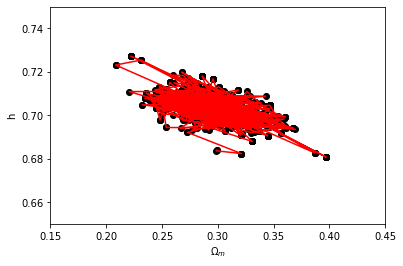

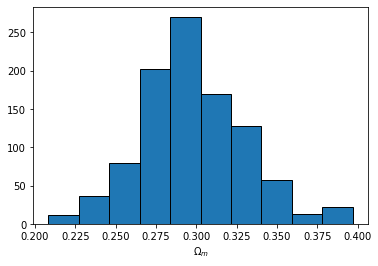

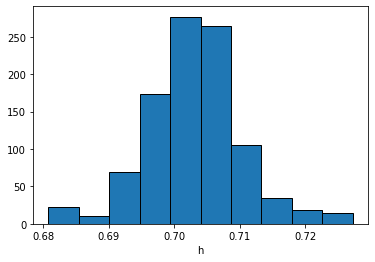

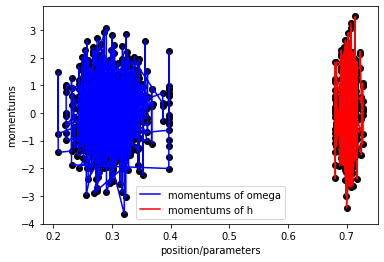

Mean value of Omegam =  0.297687249670374
Mean value of h      =  0.7031087718026467
standard deviation of Omegam =  0.03265914293588578
standard deviation of h      =  0.007368884321926658
acceptance rate= 69.7


In [ ]:
# Remove a burn in period, arbitrarily chosen to be the first 10% of the chain:
#nburn = math.floor((nsamples*0.1)/100)

nburn=10
 
# Scatter plot of the samples:
fig = plt.figure()
plt.plot(Theta[:,0], Theta[:,1],'o',color='black')
plt.plot(Theta[:,0], Theta[:,1],'r-')
plt.xlim(0.15,0.45)
plt.ylim(0.65,0.75)
plt.xlabel(r'$\Omega_m$')
plt.ylabel('h')
plt.show()
fig.savefig('g2.jpg')
 
 
# Histogram of Omegam:
fig = plt.figure()
plt.hist(Theta[nburn:,0],bins=10,ec='black')
plt.xlabel(r'$\Omega_m$')
plt.show()
fig.savefig('g4.jpg')
 
# Histogram of h:
fig = plt.figure()
plt.hist(Theta[nburn:,1],bins=10,ec='black')
plt.xlabel('h')
plt.show() 
fig.savefig('g5.jpg')
 
#momentum vs position space:
fig=plt.figure()
plt.xlabel('position/parameters')
plt.ylabel('momentums')
plt.plot(Theta[:,0],omegap[:],'o',color='black')
 
plt.plot(Theta[:,0],omegap[:],color='blue',label='momentums of omega')
plt.legend()
plt.plot()
plt.plot(Theta[:,1],hp[:],'o',color='black')
plt.plot(Theta[:,1],hp[:],color='red',label='momentums of h')
plt.legend()
plt.show()
fig.savefig('momentum.jpg')
 
accep=accep-nburn
# Print mean of parameters, after removing a burn-in of 10% of samples:
 
print ('Mean value of Omegam = ',np.mean(Theta[nburn:nsamples,0]))
print ('Mean value of h      = ',np.mean(Theta[nburn:nsamples,1]))
print ('standard deviation of Omegam = ',np.std(Theta[nburn:nsamples,0]))
print ('standard deviation of h      = ',np.std(Theta[nburn:nsamples,1]))
print('acceptance rate=',(accep*100)/nsamples)

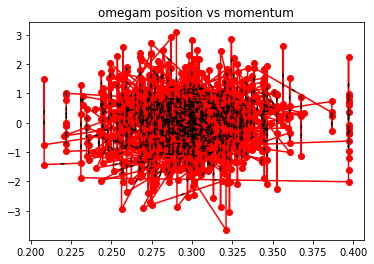

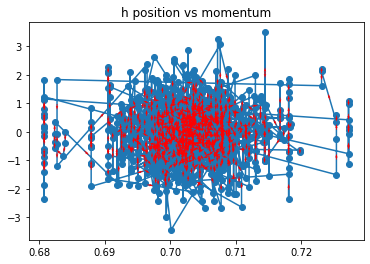

In [ ]:
x=Theta[0::1,0]
y=omegap[0::1]
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/2
pos_y = y[:-1] + v/2
norm = np.sqrt(u**2+v**2) 

fig, ax = plt.subplots()
ax.plot(x[:],y[:], marker="o",color='red')
plt.title('omegam position vs momentum')
ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid",color='black')
plt.show()
x=Theta[0::1,1]
y=hp[0::1]
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/2
pos_y = y[:-1] + v/2
norm = np.sqrt(u**2+v**2) 
fig, ax = plt.subplots()
ax.plot(x[:],y[:], marker="o")
#plt.xlim(0.5,0.78)
plt.title('h position vs momentum')
ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid",color='red')
plt.show()



In [ ]:
s=min(uy(ys)[-1],uy(ys)[0])
arg=np.argwhere(uy(ys)<s)

minh=min(ys[arg[0][0]],ys[arg[-1][0]])
maxh=max(ys[arg[0][0]],ys[arg[-1][0]])
print(minh,maxh)
print(uy(ys)[arg[0][0]],uy(ys)[arg[-1][0]])



0.4141414141414142 0.98989898989899
861.1079904834787 849.4989346475486


In [ ]:
s=min(ux(xs)[-1],ux(xs)[0])
arg=np.argwhere(ux(xs)<s)
mino=min(xs[arg[0][0]],xs[arg[-1][0]])
maxo=max(xs[arg[0][0]],xs[arg[-1][0]])
print(mino,maxo)
print(ux(xs)[arg[0][0]],ux(xs)[arg[-1][0]])

0.010101010101010102 0.595959595959596
62.32752132928978 64.71626389046423


Diagnostics

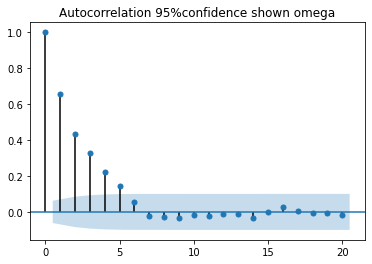

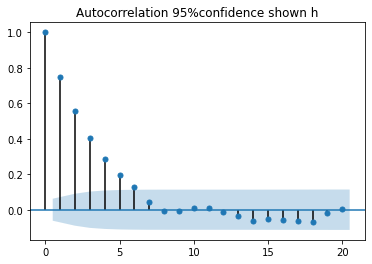

In [ ]:
from pandas import Series
import statistics
#from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from pandas import DataFrame
#from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf

series=Series(Theta[:,0])


plot_acf(series,lags=20,title='Autocorrelation 95%confidence shown omega')
plt.show()



series=Series(Theta[:,1])


plot_acf(series,lags=20,title='Autocorrelation 95%confidence shown h')
plt.show()


In [ ]:
print(accep)
pl=acf(Theta[:,0],nlags=10,fft='false')
L=1+2*(np.sum(pl))
print("autocorrelation length is {}".format(L))

697
autocorrelation lenghth is 6.572273672426216


#Chain generated:

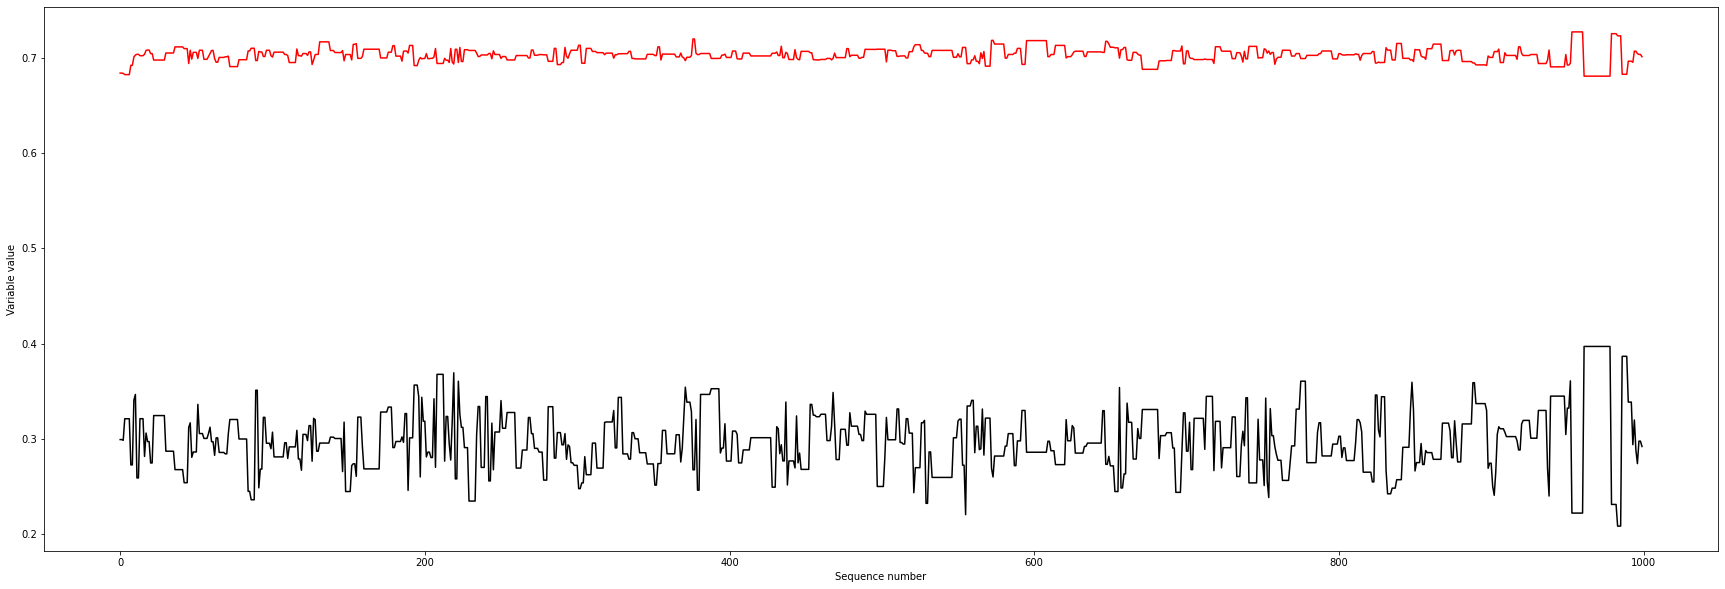

In [ ]:
id=[i for i in range(len(Theta[:,0]))]
fig=plt.figure(figsize=(30,10))
plt.plot(id[:1000],Theta[:1000,0],'-',color='black')

#fig=plt.figure(figsize=(30,5))
plt.plot(id[:1000],Theta[:1000,1],'-',color='red')
plt.xlabel('Sequence number')
plt.ylabel('Variable value')
plt.show()

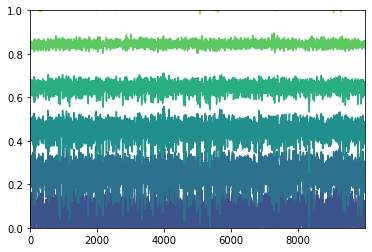

In [ ]:
plt.contour([Theta[:,0],Theta[:,1]])